# Purpose

Attempt to perform a logistic regression on the cves/metasploit dataset

In [168]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
import numpy as np

from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, fbeta_score, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import fbeta_score, make_scorer


%matplotlib inline


In [169]:
CVES_METASPLOIT_ENCODED = '../../data/processed/cves_metasplot_encoded.json'

In [170]:
cves_df = pd.read_json(CVES_METASPLOIT_ENCODED)
cves_df.head()

,access_ADJACENT,access_LOCAL,access_NETWORK,auth_HIGH,auth_LOW,auth_NONE,avail_HIGH,avail_LOW,avail_NONE,comp_HIGH,comp_LOW,conf_HIGH,conf_LOW,conf_NONE,id,integ_HIGH,integ_LOW,integ_NONE,metasploit
0,0,0,1,0,0,1,0,1,0,0,1,0,0,1,CVE-1999-0001,0,0,1,0
1,0,0,1,0,0,1,1,0,0,0,1,1,0,0,CVE-1999-0002,1,0,0,0
2,0,0,1,0,0,1,1,0,0,0,1,1,0,0,CVE-1999-0003,1,0,0,0
3,0,0,1,0,0,1,0,1,0,0,1,0,0,1,CVE-1999-0004,0,0,1,0
4,0,0,1,0,0,1,1,0,0,0,1,1,0,0,CVE-1999-0005,1,0,0,0


In [171]:
cves_df['metasploit'].value_counts()

0    103268
1      1657
Name: metasploit, dtype: int64

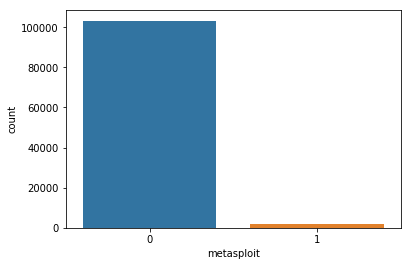

In [172]:
sns.countplot(x='metasploit', data=cves_df)

In [173]:
cves_df.groupby('metasploit').mean()

,access_ADJACENT,access_LOCAL,access_NETWORK,auth_HIGH,auth_LOW,auth_NONE,avail_HIGH,avail_LOW,avail_NONE,comp_HIGH,comp_LOW,conf_HIGH,conf_LOW,conf_NONE,integ_HIGH,integ_LOW,integ_NONE
metasploit,,,,,,,,,,,,,,,,,
0,0.023424,0.167002,0.809573,0.012385,0.128481,0.859134,0.351580,0.31702,0.331400,0.064018,0.935982,0.320632,0.385240,0.294128,0.295493,0.424827,0.279680
1,0.005432,0.064575,0.929994,0.006035,0.098974,0.894991,0.590827,0.28968,0.119493,0.047073,0.952927,0.604707,0.317441,0.077852,0.575739,0.283645,0.140616


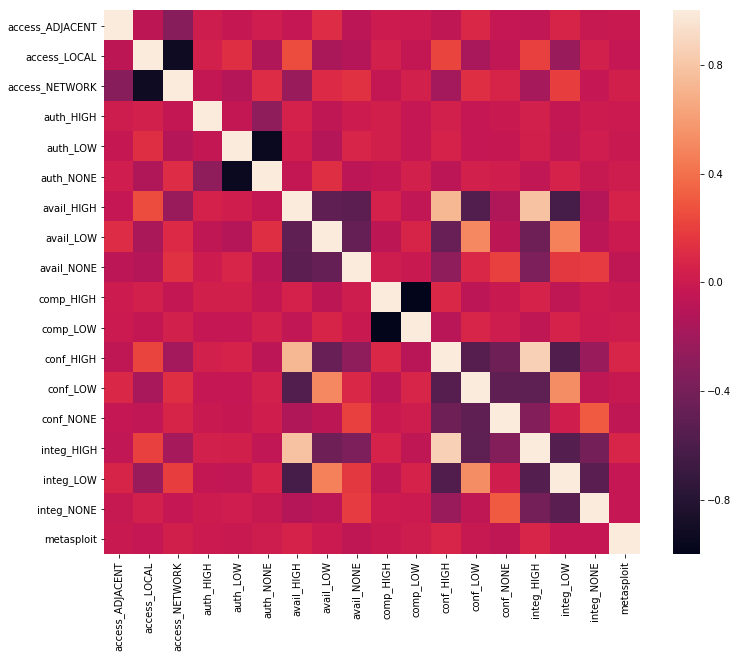

In [174]:
fig, ax = plt.subplots(figsize=(12,10))         # Sample figsize in inches

sns.heatmap(cves_df.corr(), ax=ax)
plt.savefig('../../docs/img/corr_heatmap.png')

In [175]:
cves_df.columns

Index(['access_ADJACENT', 'access_LOCAL', 'access_NETWORK', 'auth_HIGH',
       'auth_LOW', 'auth_NONE', 'avail_HIGH', 'avail_LOW', 'avail_NONE',
       'comp_HIGH', 'comp_LOW', 'conf_HIGH', 'conf_LOW', 'conf_NONE', 'id',
       'integ_HIGH', 'integ_LOW', 'integ_NONE', 'metasploit'],
      dtype='object')

In [176]:
X = cves_df.drop(['metasploit', 'id'], axis=1)
y = cves_df['metasploit']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [177]:
y_train.mean()

0.015566822970276898

In [178]:
y_test.mean()

0.01646843549862763

In [179]:
classifier = LogisticRegression(random_state=0, class_weight="balanced")
classifier.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=0,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [180]:
y_pred = classifier.predict(X_test)


In [181]:
pd.crosstab(y_test, y_pred, rownames=['True'], colnames=['Predicted'], margins=True)


Predicted,0,1,All
True,,,
0,15075,10725,25800
1,105,327,432
All,15180,11052,26232


In [182]:
print(confusion_matrix(y_test, y_pred))

[[15075 10725]
 [  105   327]]


In [183]:
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(classifier.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.59


In [184]:
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.99      0.58      0.74     25800
          1       0.03      0.76      0.06       432

avg / total       0.98      0.59      0.72     26232



out of the 25737 CVEs we have only 430 of them required us to inspect them, the predictor said to inspect 10043, so we looked at nearly 40%, or another way, we had a 60% reduction in cves to inspect.  That's good, but not great, specially since it resulted in missing nearly 25% of the positives: 102 were exploited without triggering a positive.  Much like SPAM, we want to minimize False Negatives

In [185]:
y_pred_prob = classifier.predict_proba(X_test)

In [186]:
thresh = .7
y_pred_thresh = [1 if pred[1] > thresh else 0 for pred in y_pred_prob]
matrix = confusion_matrix(y_test, y_pred_thresh)
(matrix[1][0], matrix[0][1]+matrix[1][1])

(213, 4680)

In [187]:
def get_rates(thresh):
    y_pred_thresh = [1 if pred[1] > thresh else 0 for pred in y_pred_prob]
    matrix = confusion_matrix(y_test, y_pred_thresh)
    return matrix

results = []
for a in range(100, 0, -1):
    thresh = a/100
    matrix = get_rates(thresh)
    results.append((thresh, matrix))

In [188]:
results[50][1]

array([[15075, 10725],
       [  105,   327]], dtype=int64)

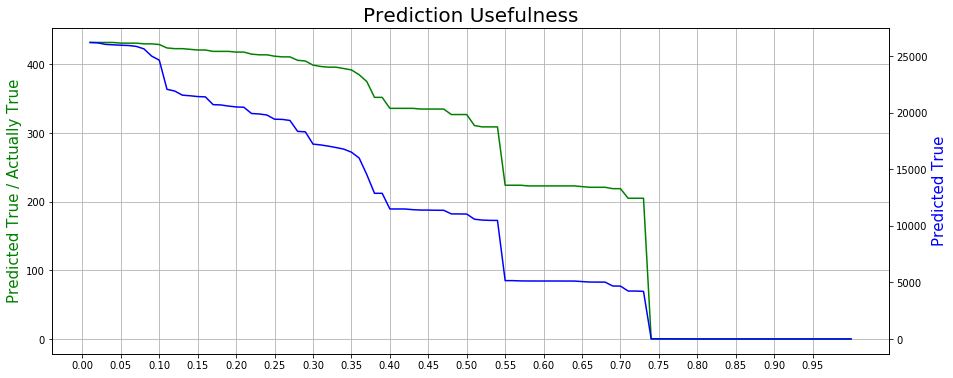

In [189]:
# Lets plot True-Positives against all True
title_size=20
labelsize=15
ticksize=10

thresh_x = [x[0] for x in results]
tp_y = [x[1][1][1] for x in results]
t_y = [x[1][0][1]+x[1][1][1] for x in results]

fig, ax1 = plt.subplots(figsize=(15,6))

ax2 = ax1.twinx()
ax1.plot(thresh_x, tp_y, 'g')
ax2.plot(thresh_x, t_y, 'b')

plt.title('Prediction Usefulness', fontsize=title_size)
ax1.set_ylabel('Predicted True / Actually True', color='g', fontsize=labelsize)
ax2.set_ylabel('Predicted True', color='b', fontsize=labelsize)
plt.xlabel('Threshold', fontsize=labelsize)
xticks = [x/100 for x in range(0,100,5)]
plt.xticks(xticks)
ax1.grid(True)
plt.savefig('../../docs/img/avp.png')




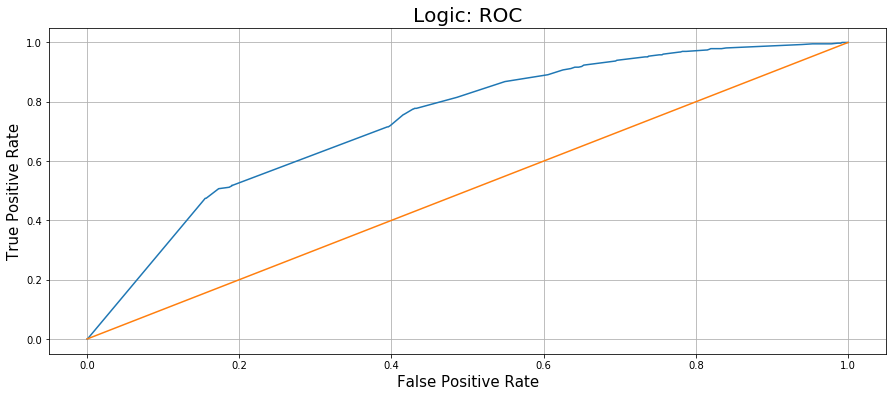

In [190]:
# lets plot the ROC curve now
# true positive rate (TPR) against the false positive rate (FPR)
title_size=20
labelsize=15
ticksize=10

# Num FP / 
tp_rate_y = [x[1][1][1]/(x[1][1][1]+x[1][1][0]) for x in results]
fp_rate_x = [x[1][0][1]/(x[1][0][1]+x[1][0][0]) for x in results]

fig, ax1 = plt.subplots(figsize=(15,6))

ax1.plot(fp_rate_x, tp_rate_y)
ax1.plot([0,1], [0,1])
plt.title('Logic: ROC', fontsize=title_size)
ax1.set_ylabel('True Positive Rate', fontsize=labelsize)
ax1.set_xlabel('False Positive Rate', fontsize=labelsize)

ax1.tick_params(labelsize=ticksize)
ax1.grid(True)
plt.savefig('../../docs/img/roc.png')



In [191]:
thresh = 0.5
y_pred_thresh = np.array([1 if pred[1] > thresh else 0 for pred in y_pred_prob])
matrix = confusion_matrix(y_test, y_pred_thresh)
display(pd.crosstab(y_test, y_pred_thresh, rownames=['True'], colnames=['Predicted'], margins=True))
print(matrix)
print(classification_report(y_test, y_pred_thresh))
print("F10 Score        :", fbeta_score(y_test, y_pred_thresh, 10))

Predicted,0,1,All
True,,,
0,15075,10725,25800
1,105,327,432
All,15180,11052,26232


[[15075 10725]
 [  105   327]]
             precision    recall  f1-score   support

          0       0.99      0.58      0.74     25800
          1       0.03      0.76      0.06       432

avg / total       0.98      0.59      0.72     26232

F10 Score        : 0.6087701835877017


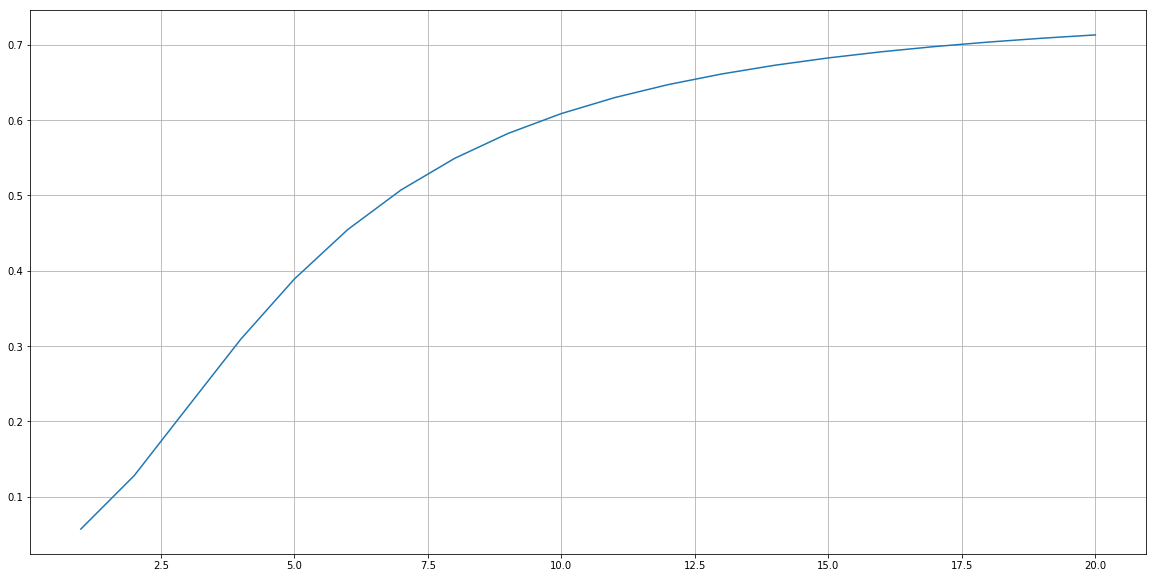

In [192]:
fbeta_test = [(fbeta, fbeta_score(y_test, y_pred_thresh, fbeta)) for fbeta in range(1, 21)]
fbeta_test_y = [test[0] for test in fbeta_test]
fbeta_test_x = [test[1] for test in fbeta_test]
plt.figure(figsize=(20,10))
plt.plot(fbeta_test_y, fbeta_test_x)
plt.grid(True)

In [193]:
# lets check all f-betas from 1-10 in increments of 2

def f_beta_score(thresh, fbeta):
    y_pred_thresh = [1 if pred[1] > thresh else 0 for pred in y_pred_prob]
    score = fbeta_score(y_test, y_pred_thresh, fbeta)
    return score

def get_f_beta_scores(fbeta):
    fscore_results = []
    for a in range(100, 0, -1):
        thresh = a/100
        score = f_beta_score(thresh, fbeta)
        fscore_results.append((thresh, score))
    return fscore_results

all_fscore_results = [(fbeta, get_f_beta_scores(fbeta)) for fbeta in range(2, 21, 2)]

C:\Users\kenfa\AppData\Local\Continuum\anaconda3\envs\mlnd\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\kenfa\AppData\Local\Continuum\anaconda3\envs\mlnd\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\kenfa\AppData\Local\Continuum\anaconda3\envs\mlnd\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\kenfa\AppData\Local\Continuum\anaconda3\envs\mlnd\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  '

C:\Users\kenfa\AppData\Local\Continuum\anaconda3\envs\mlnd\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\kenfa\AppData\Local\Continuum\anaconda3\envs\mlnd\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\kenfa\AppData\Local\Continuum\anaconda3\envs\mlnd\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\kenfa\AppData\Local\Continuum\anaconda3\envs\mlnd\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  '

C:\Users\kenfa\AppData\Local\Continuum\anaconda3\envs\mlnd\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\kenfa\AppData\Local\Continuum\anaconda3\envs\mlnd\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\kenfa\AppData\Local\Continuum\anaconda3\envs\mlnd\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\kenfa\AppData\Local\Continuum\anaconda3\envs\mlnd\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  '

C:\Users\kenfa\AppData\Local\Continuum\anaconda3\envs\mlnd\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\kenfa\AppData\Local\Continuum\anaconda3\envs\mlnd\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\kenfa\AppData\Local\Continuum\anaconda3\envs\mlnd\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\kenfa\AppData\Local\Continuum\anaconda3\envs\mlnd\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  '

C:\Users\kenfa\AppData\Local\Continuum\anaconda3\envs\mlnd\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\kenfa\AppData\Local\Continuum\anaconda3\envs\mlnd\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\kenfa\AppData\Local\Continuum\anaconda3\envs\mlnd\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\kenfa\AppData\Local\Continuum\anaconda3\envs\mlnd\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  '

C:\Users\kenfa\AppData\Local\Continuum\anaconda3\envs\mlnd\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\kenfa\AppData\Local\Continuum\anaconda3\envs\mlnd\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\kenfa\AppData\Local\Continuum\anaconda3\envs\mlnd\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\kenfa\AppData\Local\Continuum\anaconda3\envs\mlnd\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  '

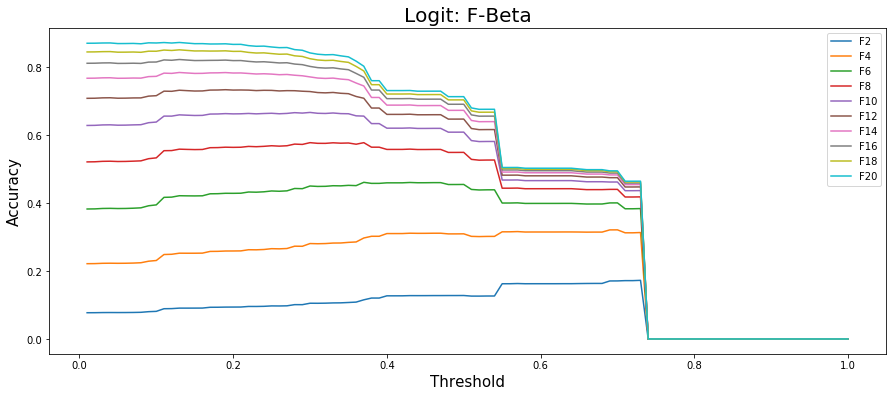

In [194]:

title_size=20
labelsize=15
ticksize=10

thresh_x = [x[0] for x in all_fscore_results[0][1]]

plt.figure(figsize=(15,6))
for i, fscore_result in enumerate(all_fscore_results):
    
    fscore = all_fscore_results[i][0]
    next_y = [x[1] for x in all_fscore_results[i][1]]

    plt.plot(thresh_x, next_y, label='F{0}'.format(fscore))

plt.legend()

plt.title('Logit: F-Beta', fontsize=title_size)
plt.xlabel('Threshold', fontsize=labelsize)
plt.ylabel('Accuracy', fontsize=labelsize)
plt.tick_params(labelsize=ticksize)
plt.savefig('../../docs/img/f-beta.png')


Using the above f10 was decided to be used as our scoring

In [195]:
param_grid = [
  {'C': [0.1, 0.25, 0.5, 0.75, 1, 10, 100, 1000]}
 ]

# Using balanced since we have a 60:1 of negatives:positives
model = LogisticRegression(random_state=0, class_weight="balanced")

f10_scorer = make_scorer(fbeta_score, beta=10)

grid_search_model = GridSearchCV(model, param_grid=param_grid, scoring=f10_scorer, cv=5, n_jobs=-1)

grid_search_model.fit(X_train, y_train)

print(grid_search_model)
print(grid_search_model.best_score_)
print(grid_search_model.best_params_)

GridSearchCV(cv=5, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=0,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid=[{'C': [0.1, 0.25, 0.5, 0.75, 1, 10, 100, 1000]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(fbeta_score, beta=10), verbose=0)
0.6105013081139327
{'C': 0.25}


In [204]:
model = LogisticRegression(C=0.25, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=0,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

display(pd.crosstab(y_test, y_pred, rownames=['True'], colnames=['Predicted'], margins=True))
print("Training Accuracy:", model.score(X_train, y_train))
print("Test Accuracy    :", model.score(X_test, y_test))
print("F10 Score        :", fbeta_score(y_test, y_pred, 10))
print()
print(classification_report(y_test, y_pred))


Predicted,0,1,All
True,,,
0,15075,10725,25800
1,105,327,432
All,15180,11052,26232


Training Accuracy: 0.5931404318046077
Test Accuracy    : 0.5871454711802379
F10 Score        : 0.6087701835877017

             precision    recall  f1-score   support

          0       0.99      0.58      0.74     25800
          1       0.03      0.76      0.06       432

avg / total       0.98      0.59      0.72     26232



In [197]:
X_train.columns

Index(['access_ADJACENT', 'access_LOCAL', 'access_NETWORK', 'auth_HIGH',
       'auth_LOW', 'auth_NONE', 'avail_HIGH', 'avail_LOW', 'avail_NONE',
       'comp_HIGH', 'comp_LOW', 'conf_HIGH', 'conf_LOW', 'conf_NONE',
       'integ_HIGH', 'integ_LOW', 'integ_NONE'],
      dtype='object')

In [198]:
print(model.coef_)

[[-0.91247484 -0.56013658  0.91398278 -0.78906885  0.03982814  0.19061208
  -0.04044939  0.31377552 -0.83195477 -0.42086745 -0.13776118  0.65210406
  -0.01394699 -1.19678571  0.02132791 -0.51774174 -0.0622148 ]]


In [199]:
print(sorted(model.coef_[0]))

[-1.196785709666014, -0.9124748355721914, -0.8319547681363507, -0.7890688500182756, -0.560136577404151, -0.5177417440818303, -0.42086745211384397, -0.1377611820450946, -0.06221479526091196, -0.04044938567563493, -0.013946987538648337, 0.021327905232898892, 0.03982813862547228, 0.19061207724217896, 0.3137755196819219, 0.652104063089461, 0.9139827788049408]
